## Loading the combined CSV to memory

In [111]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

%load_ext rpy2.ipython
%load_ext memory_profiler

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [144]:
!pip install matplotlib

### Loading in Chunks

In [2]:
def get_counts(column, file = "../data/ACCESS-CM2_daily_rainfall_NSW.csv"):
    counts = pd.Series(dtype=int)

    for chunk in pd.read_csv(file, chunksize=10_000):
        counts = counts.add(chunk[column].value_counts(), fill_value=0)

    return counts

In [84]:
chunk_mem = %memit -o get_counts('lat_max')
chunk_time = %timeit -o get_counts('lat_max')

peak memory: 217.21 MiB, increment: 12.07 MiB
5.03 s ± 710 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Dask

In [93]:
dask_mem = %memit -o dd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv")['lat_max'].value_counts().compute()
dask_time = %timeit -o dd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv")['lat_max'].value_counts().compute()

peak memory: 628.03 MiB, increment: 421.87 MiB
1.68 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Loading only columns of interest

In [94]:
col_subset_mem = %memit -o pd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv", usecols=['lat_max'])['lat_max'].value_counts()
col_subset_time = %timeit -o pd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv", usecols=['lat_max'])['lat_max'].value_counts()

peak memory: 245.17 MiB, increment: 39.38 MiB
1.21 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Loading with `low_memory=True`

In [102]:
low_mem = %memit -o pd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv", usecols=['lat_max'],low_memory=True)['lat_max'].value_counts()
low_time = %timeit -o pd.read_csv("../data/ACCESS-CM2_daily_rainfall_NSW.csv", usecols=['lat_max'],low_memory=True)['lat_max'].value_counts()

peak memory: 242.94 MiB, increment: 36.08 MiB
1.17 s ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison

In [106]:
analysis = pd.DataFrame({
    "Method": ["Chunking", "Dask", "Subsetting Columns", "Low Memory"],
    "Time": [np.mean(chunk_time.all_runs), np.mean(dask_time.all_runs), np.mean(col_subset_time.all_runs), np.mean(low_time.all_runs)],
    "Memory": [chunk_mem.mem_usage[0], dask_mem.mem_usage[0], col_subset_mem.mem_usage[0], low_mem.mem_usage[0]]
})

analysis

,Method,Time,Memory
0,Chunking,5.025813,217.207031
1,Dask,1.677578,628.031250
2,Subsetting Columns,1.207815,245.171875
3,Low Memory,1.170877,242.937500


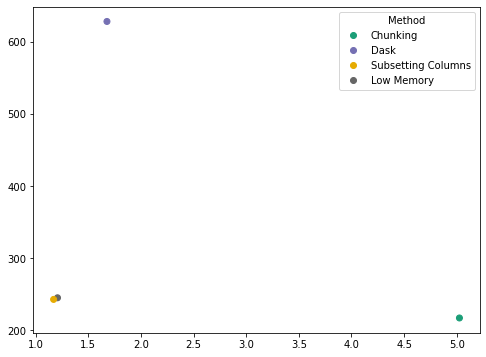

In [143]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(analysis.Time, analysis.Memory, c = pd.Categorical(analysis.Method).codes, cmap='Dark2')
ax.legend(sc.legend_elements()[0], analysis.Method, title="Method")
plt.show()

## Discussion

From the experiments, The slowest was chunking. This makes sense since we would have to do multiple iterations to get through the entire data. However, the trade off was the amount of memory used: Chunking used the least amount of memory among all methods tested. 

The fastest method was loading only the column of interest. This was faster than using Dask. The use of `low_memory=True` did not affect the memory usage by much. If we were to pick one of these methods, it would be the column sub-setting method. 